<a href="https://www.kaggle.com/code/georgelukaanya/temperature-humidity-and-co2-vs-weight?scriptVersionId=226248312" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import calendar

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Load the data and set the 'created_at' column as the index
carbondioxide = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_carbondioxide_APR_FEB_hive1.csv', index_col='created_at')
humidity = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_humidity_APR_FEB_hive1.csv', index_col='created_at')
temperatures = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_temperatures_APR_FEB_hive1.csv', index_col='created_at')
weights = pd.read_csv('/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_weights_APR_FEB_hive1.csv', index_col='created_at')

# Convert the index to datetime
carbondioxide.index = pd.to_datetime(carbondioxide.index)
humidity.index = pd.to_datetime(humidity.index)
temperatures.index = pd.to_datetime(temperatures.index)
weights.index = pd.to_datetime(weights.index)


# Check for and remove duplicates in the index
humidity = humidity[~humidity.index.duplicated(keep='first')]
carbondioxide = carbondioxide[~carbondioxide.index.duplicated(keep='first')]
temperatures = temperatures[~temperatures.index.duplicated(keep='first')]
weights = weights[~weights.index.duplicated(keep='first')]

In [4]:
#Cleaning the humidity data
# Replace '*2*' with a comma in the 'record' column
humidity['record'] = humidity['record'].str.replace('*2*', ',', regex=False)

# Split the 'record' column and assign to new columns
humidity[['Interior (%)', 'Exterior (%)']] = humidity['record'].str.split(',', expand=True)

# Drop the 'record' column as it's no longer needed
humidity = humidity.drop(columns=['record'])

# Convert new columns to numeric types
humidity['Interior (%)'] = pd.to_numeric(humidity['Interior (%)'], errors='coerce')
humidity['Exterior (%)'] = pd.to_numeric(humidity['Exterior (%)'], errors='coerce')

# Replace values of 2 with NaN (without inplace to avoid warnings)
humidity['Interior (%)'] = humidity['Interior (%)'].replace(2, np.nan)
humidity['Exterior (%)'] = humidity['Exterior (%)'].replace(2, np.nan)

# Display the resulting DataFrame
humidity.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Interior (%),Exterior (%)
created_at,,
2024-04-02 14:52:03,NaN,NaN
2024-04-02 14:54:00,NaN,NaN
2024-04-02 15:06:05,NaN,NaN
2024-04-02 15:54:12,NaN,NaN
2024-04-03 17:08:06,94.2,84.3


In [5]:
#Cleaning the CO2 data
#replacing 2 with NaN
carbondioxide['record'] = carbondioxide.record.replace(2, np.nan)
carbondioxide.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,record
created_at,
2024-04-02 14:52:00,NaN
2024-04-02 14:54:00,661.0
2024-04-02 15:06:00,530.0
2024-04-02 15:54:00,405.0
2024-04-03 17:08:00,7330.0


In [6]:
#Cleaning the weights data, replacing the 2 with NaN
weights.record = weights.record.replace(2, np.nan)
weights.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,record
created_at,
2024-04-02 14:52:03,NaN
2024-04-02 14:54:00,103.0
2024-04-02 15:06:05,96.0
2024-04-02 15:54:12,NaN
2024-04-03 17:08:06,15.0


In [7]:
#Cleaning the temperature data
# Replace '*2*' with a comma in the 'record' column
temperatures['record'] = temperatures['record'].str.replace('*2*', ',', regex=False)

# Split the 'record' column and assign to new columns
temperatures[['Interior (°C)', 'Exterior (°C)']] = temperatures['record'].str.split(',', expand=True)

# Drop the 'record' column as it's no longer needed
temperatures = temperatures.drop(columns=['record'])

# Convert new columns to numeric types
temperatures['Interior (°C)'] = pd.to_numeric(temperatures['Interior (°C)'], errors='coerce')
temperatures['Exterior (°C)'] = pd.to_numeric(temperatures['Exterior (°C)'], errors='coerce')

# Replace values of 2 with NaN (without inplace to avoid warnings)
temperatures['Interior (°C)'] = temperatures['Interior (°C)'].replace(2, np.nan)
temperatures['Exterior (°C)'] = temperatures['Exterior (°C)'].replace(2, np.nan)

# Display the resulting DataFrame
temperatures.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Interior (°C),Exterior (°C)
created_at,,
2024-04-02 14:52:03,NaN,NaN
2024-04-02 14:54:00,NaN,NaN
2024-04-02 15:06:05,NaN,NaN
2024-04-02 15:54:12,NaN,NaN
2024-04-03 17:08:06,27.3,23.9


In [8]:
# Remove NaN values from each DataFrame
carbondioxide.dropna(inplace=True)
humidity.dropna(inplace=True)
temperatures.dropna(inplace=True)
weights.dropna(inplace=True)

In [16]:
import matplotlib.pyplot as plt
import calendar

# Define the months to analyze (Aug 2024 - Jan 2025)
months_to_analyze = [8, 9, 10, 11, 12, 1]
year_map = {8: 2024, 9: 2024, 10: 2024, 11: 2024, 12: 2024, 1: 2025}  # Map months to correct years

def get_monthly_data(df, month, year):
    """Filter data for the given month and year."""
    return df[(df.index.month == month) & (df.index.year == year)]

def scatter_temperature_vs_weight(month, year, temp_data, weight_data):
    """Scatter plot: Temperature (Interior & Exterior) vs. Weight for a given month."""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.scatter(temp_data.index, temp_data['Interior (°C)'], color='red', label='Interior Temp (°C)', alpha=0.7)
    ax1.scatter(temp_data.index, temp_data['Exterior (°C)'], color='blue', label='Exterior Temp (°C)', alpha=0.7)
    ax1.set_ylabel("Temperature (°C)")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.scatter(weight_data.index, weight_data['record'], color='green', label='Weight', alpha=0.7)
    ax2.set_ylabel("Weight")
    ax2.legend(loc="upper right")

    ax1.set_title(f"Scatter: Temperature vs Weight ({calendar.month_name[month]} {year})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def scatter_humidity_vs_weight(month, year, humidity_data, weight_data):
    """Scatter plot: Humidity (Interior & Exterior) vs. Weight for a given month."""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.scatter(humidity_data.index, humidity_data['Interior (%)'], color='purple', label='Interior Humidity (%)', alpha=0.7)
    ax1.scatter(humidity_data.index, humidity_data['Exterior (%)'], color='cyan', label='Exterior Humidity (%)', alpha=0.7)
    ax1.set_ylabel("Humidity (%)")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.scatter(weight_data.index, weight_data['record'], color='green', label='Weight', alpha=0.7)
    ax2.set_ylabel("Weight")
    ax2.legend(loc="upper right")

    ax1.set_title(f"Scatter: Humidity vs Weight ({calendar.month_name[month]} {year})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def scatter_co2_vs_weight(month, year, co2_data, weight_data):
    """Scatter plot: CO2 vs. Weight for a given month."""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.scatter(co2_data.index, co2_data['record'], color='brown', label='CO2 (ppm)', alpha=0.7)
    ax1.set_ylabel("CO2 (ppm)")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.scatter(weight_data.index, weight_data['record'], color='green', label='Weight', alpha=0.7)
    ax2.set_ylabel("Weight")
    ax2.legend(loc="upper right")

    ax1.set_title(f"Scatter: CO2 vs Weight ({calendar.month_name[month]} {year})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


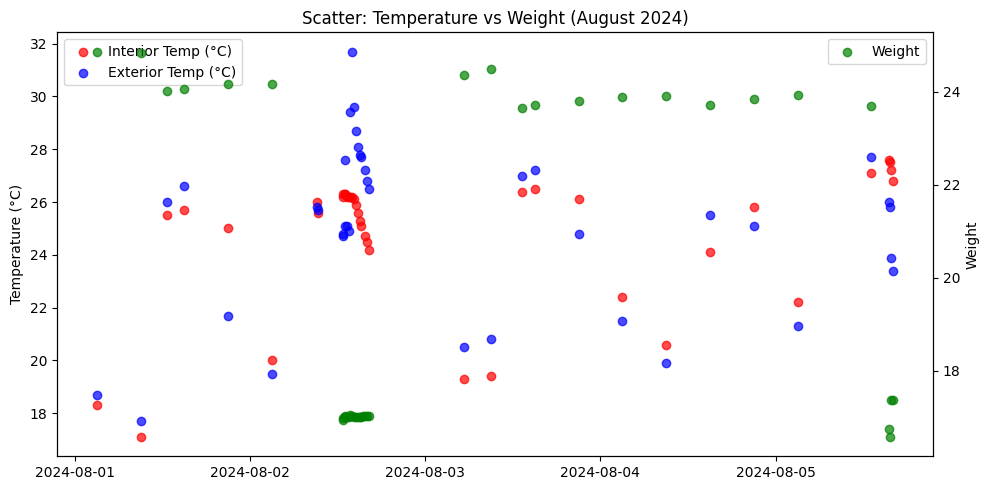

Skipping September 2024 due to insufficient data.


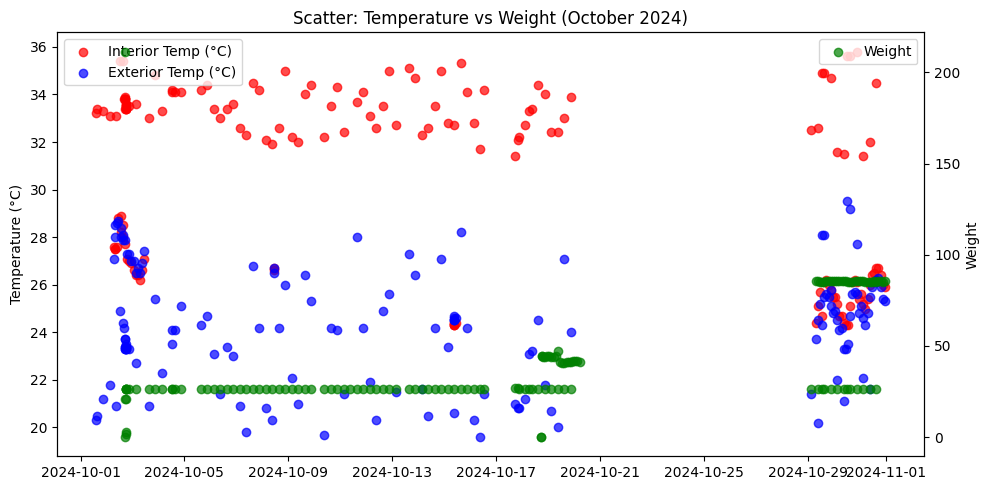

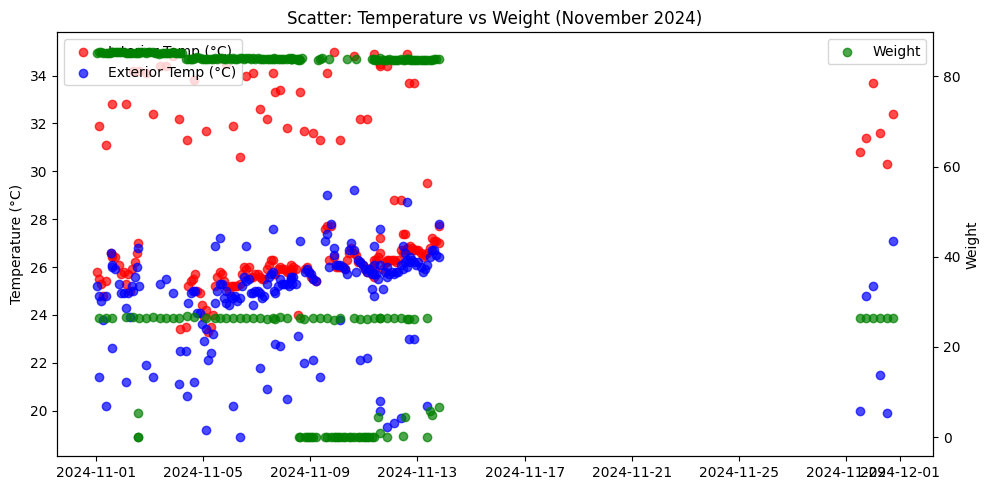

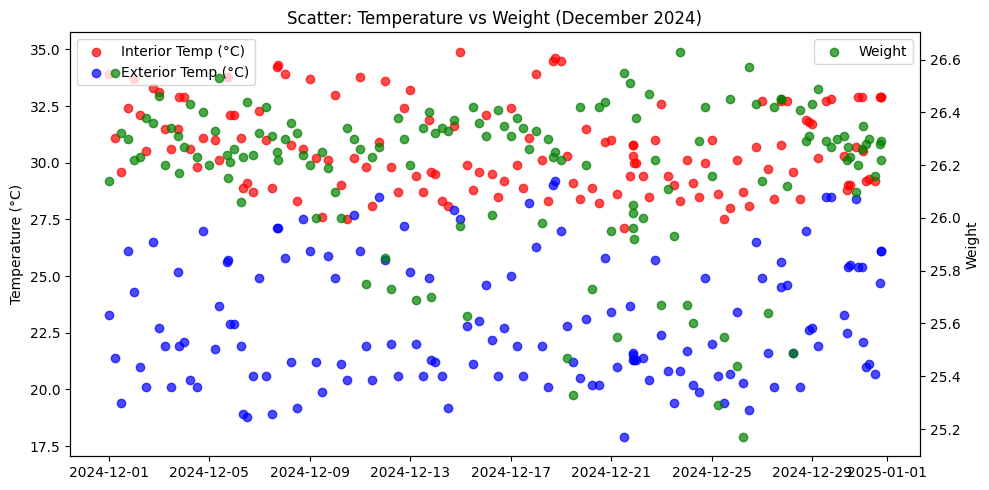

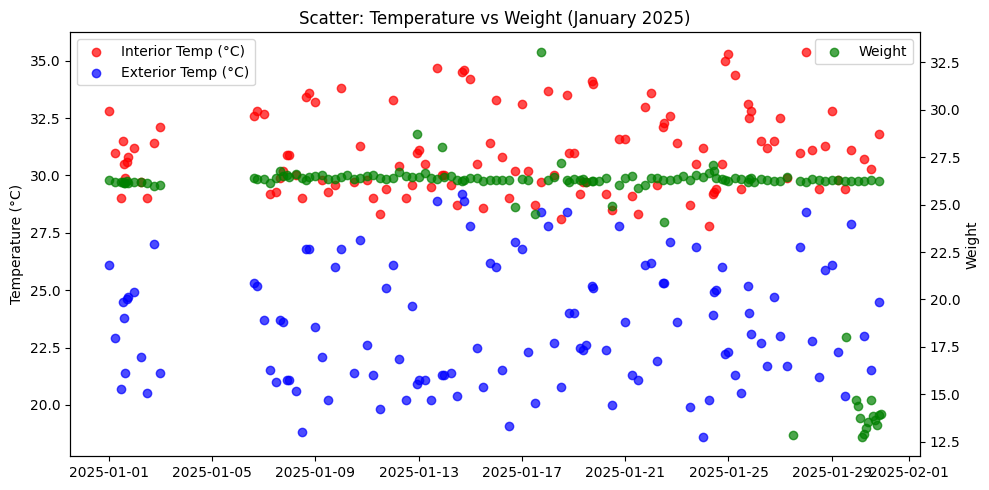

In [17]:
for month in months_to_analyze:
    year = year_map[month]
    temp_data = get_monthly_data(temperatures, month, year)
    weight_data = get_monthly_data(weights, month, year)

    if not temp_data.empty and not weight_data.empty:
        scatter_temperature_vs_weight(month, year, temp_data, weight_data)
    else:
        print(f"Skipping {calendar.month_name[month]} {year} due to insufficient data.")


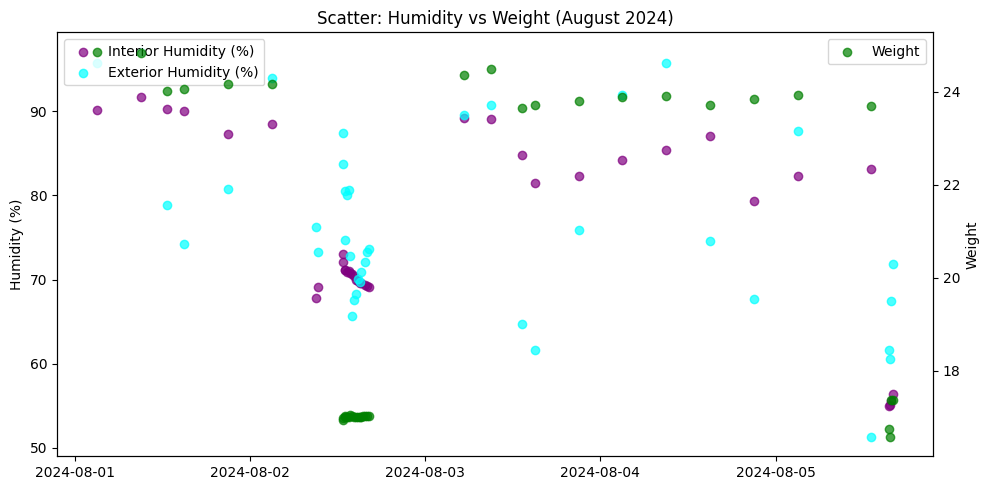

Skipping September 2024 due to insufficient data.


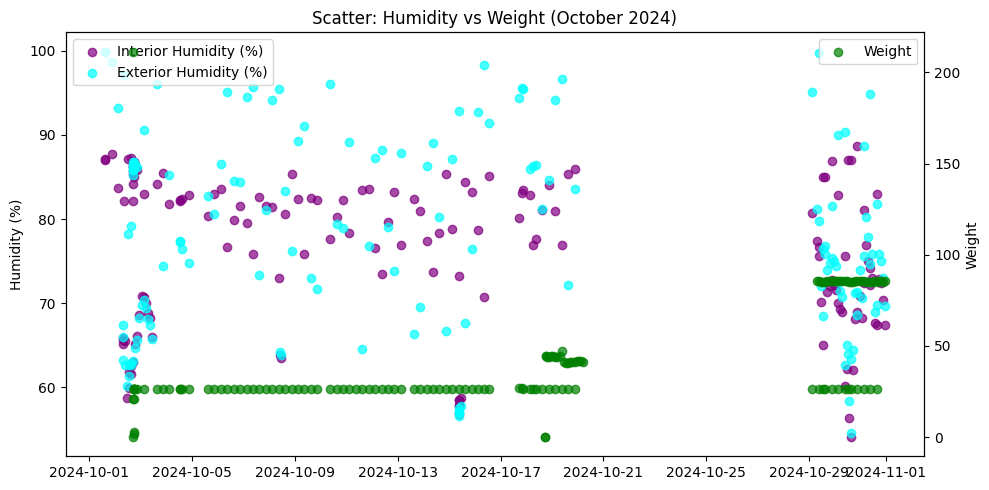

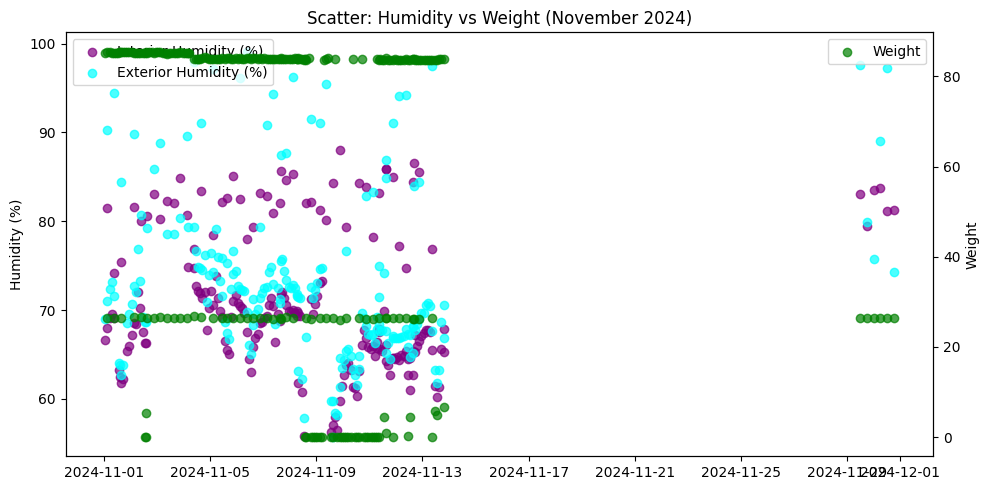

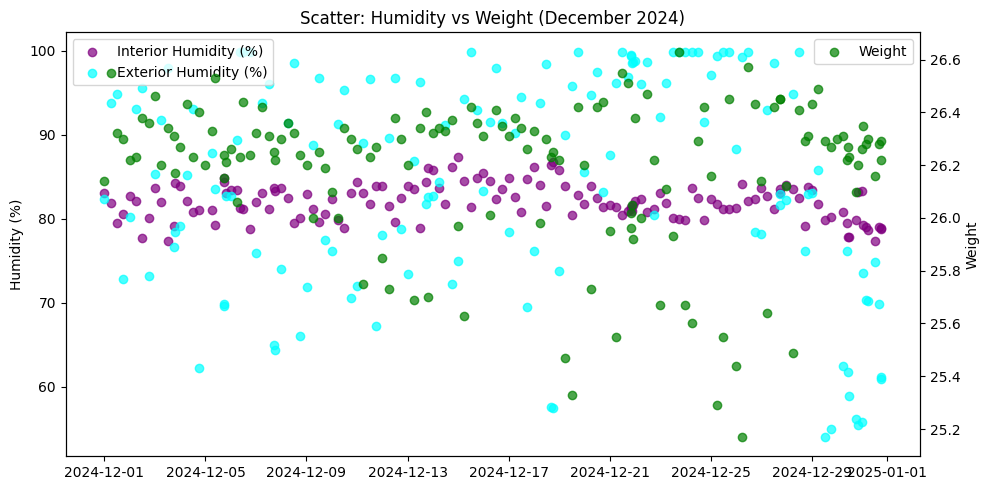

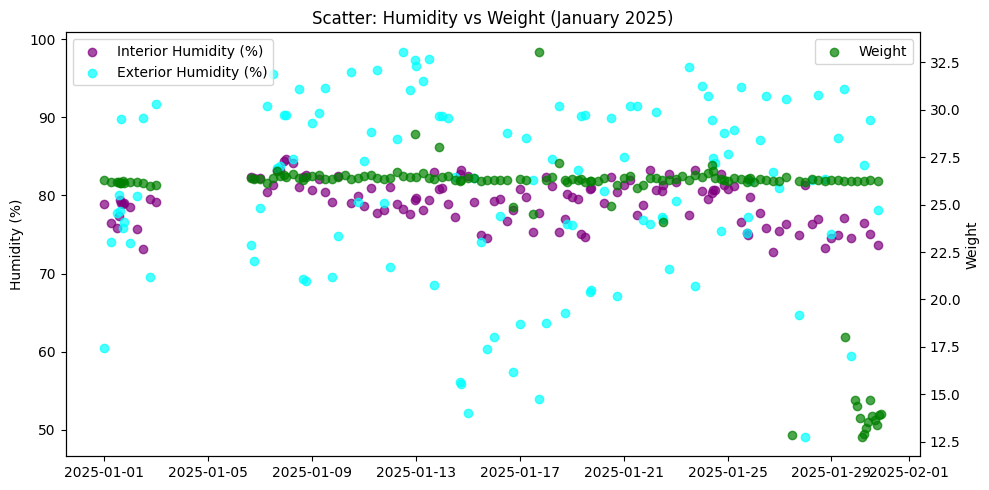

In [18]:
for month in months_to_analyze:
    year = year_map[month]
    humidity_data = get_monthly_data(humidity, month, year)
    weight_data = get_monthly_data(weights, month, year)

    if not humidity_data.empty and not weight_data.empty:
        scatter_humidity_vs_weight(month, year, humidity_data, weight_data)
    else:
        print(f"Skipping {calendar.month_name[month]} {year} due to insufficient data.")


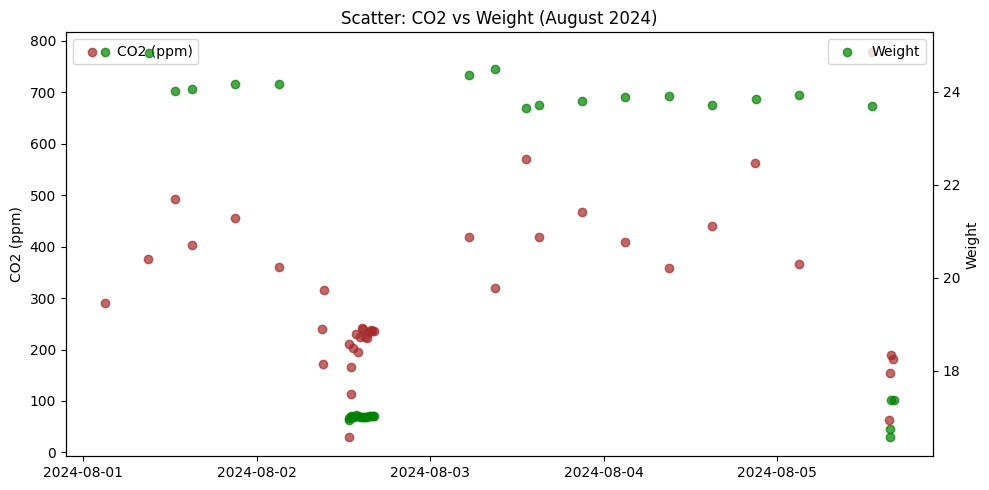

Skipping September 2024 due to insufficient data.


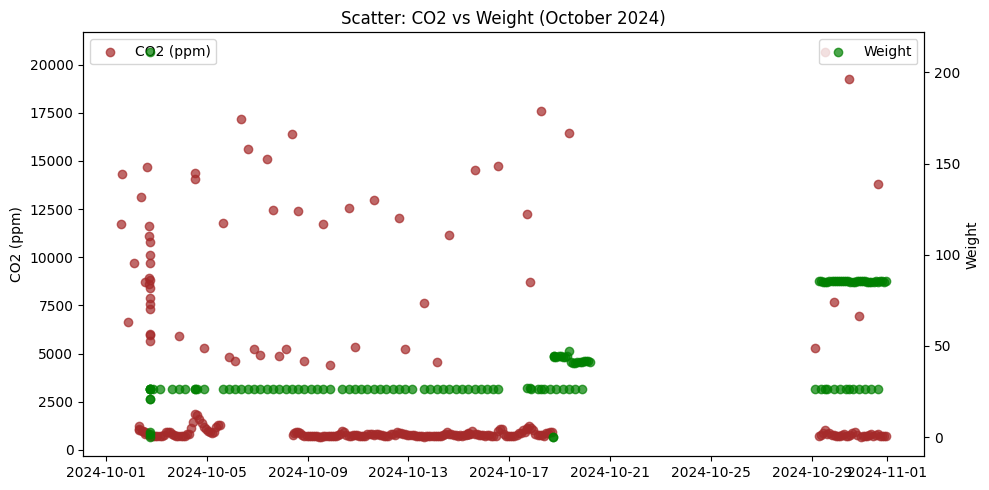

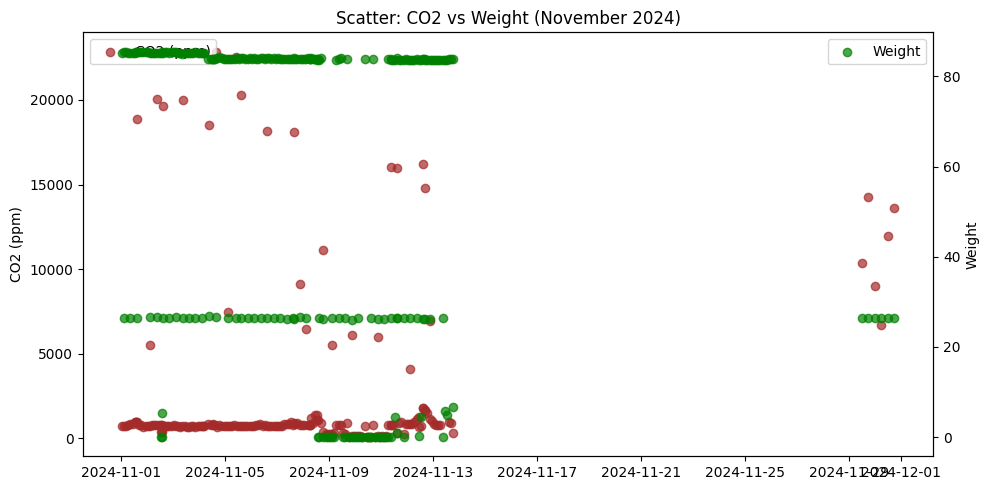

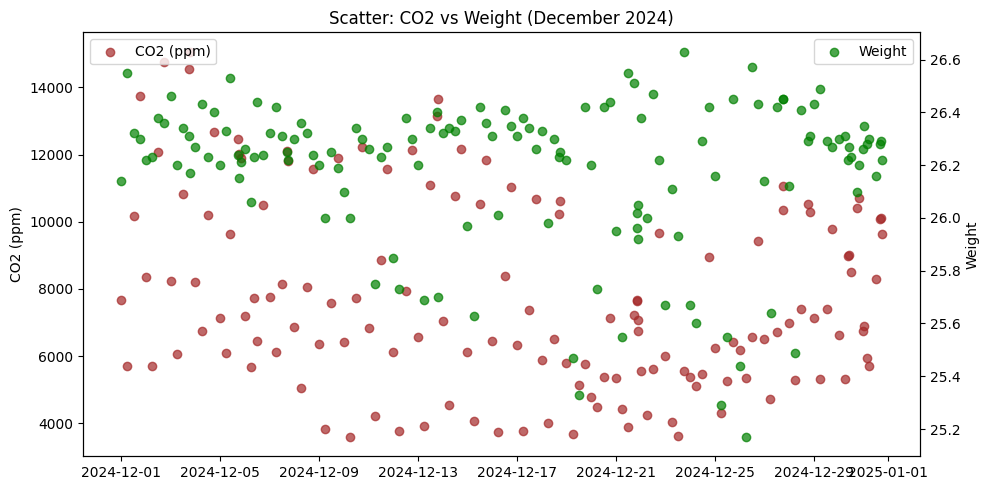

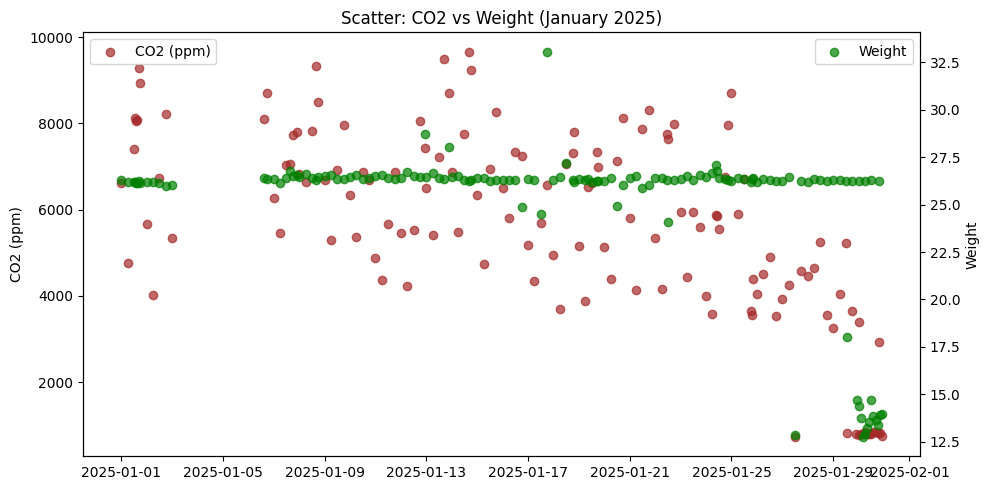

In [15]:
for month in months_to_analyze:
    year = year_map[month]
    co2_data = get_monthly_data(carbondioxide, month, year)
    weight_data = get_monthly_data(weights, month, year)

    if not co2_data.empty and not weight_data.empty:
        scatter_co2_vs_weight(month, year, co2_data, weight_data)
    else:
        print(f"Skipping {calendar.month_name[month]} {year} due to insufficient data.")